# MLP from scratch

In this notebook, we will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify cloud of points in 2D.

## 1. Import functions and data

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Function to plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

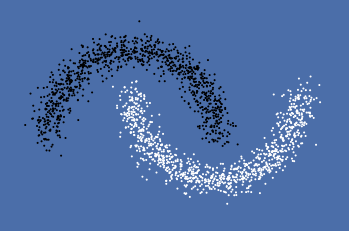

In [3]:
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [4]:
print(X.shape)

(2000, 2)


This is the dataset: two moons each one corresponding to one class (black or white in the picture above).

In order to make it more fun and illustrative, the code below allows you to see the decision boundary of your classifier

In [22]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

# 2. MLP in numpy

## 2.1 Implementation of ReLU

In [7]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.saved_x = x
        return np.maximum(0.,x)
        
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        return np.dot(np.squeeze(grad_output), np.diag(np.squeeze(self.saved_x>0)))
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        pass

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.saved_x = x
        return 1./(1. + np.exp(-x))
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        return grad_output @ np.exp(-self.saved_x) / (np.exp(-self.saved_x) + 1)**2
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        pass

**Test our functions**

In [8]:
test_relu = MyReLU()
test_relu.forward(X[10])

array([1.53551573, 0.        ])

In [9]:
test_relu.backward(1.)

array([[1., 0.],
       [0., 0.]])

In [10]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [11]:
test_sig.backward(np.ones(1))

array([0.19661193])

## 2.2. Implementation of a linear layer i.e.multiplication by a matrix W and summing with a bias b.

In [23]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        self.n_input = n_input
        self.n_output = n_output
        self.W = np.random.randn(n_input,n_output)
        self.b = np.random.randn(1,n_output)

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        self.saved_x = x
        return  x @ self.W + self.b

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        grad_diag = grad_output
        if grad_output.shape != (1,1):
            grad_diag = np.diag(grad_output.squeeze())
        self.grad_W= self.saved_x.T @ np.ones((1,self.n_output)) @ grad_diag

        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        self.grad_b=grad_output
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
       
        return grad_output @ self.W.T
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        self.W -= learning_rate*self.grad_W
        self.b -= learning_rate*self.grad_b


In [24]:
class Sequential(object):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # use the BCE loss<
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        loss = -(label * np.log(out + 1e-10) + (1-label) * np.log(1 - out + 1e-10))
        if label == 0:
            self.grad = 1./ (1 - out + 1e-10)
        elif label == 1:
            self.grad = -1./ (out + 1e-10)
        return loss

    def backward(self):
        current_grad = self.grad
        for layer in reversed(self.layers):
            current_grad = layer.backward(current_grad)
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        for layer in self.layers:
            layer.step(learning_rate)


In [25]:
h=50

# define your network with your Sequential
# it should be a linear layer with 2 inputs and h outputs, followed by a ReLU
# then a linear layer with h inputs and 1 outputs, followed by a sigmoid
# feel free to try other architectures

model = Sequential([MyLinear(2,h), MyReLU(), MyLinear(h,1), MySigmoid()])

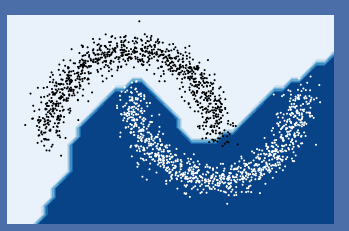

In [26]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
losses = []
learning_rate = 1e-2
for it in range(10000):
    # pick a random example id
    j = np.random.randint(1, len(X))

    # select the corresponding example and label
    example = X[j:j+1]
    label = Y[j]

    # do a forward pass on the example
    # YOUR CODE HERE
    output=model.forward(example)
    #raise NotImplementedError()

    # compute the loss according to your output and the label
    # YOUR CODE HERE
    loss = model.compute_loss(output,label)
    losses.append(loss.squeeze())
    #raise NotImplementedError()
    
    # backward pass
    # YOUR CODE HERE
    model.backward()
    #raise NotImplementedError()
    
    # gradient step
    # YOUR CODE HERE
    model.step(learning_rate)
    #raise NotImplementedError()

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, model)
        fig.canvas.draw()
plot_decision_boundary(ax, X,Y, model)
fig.canvas.draw()

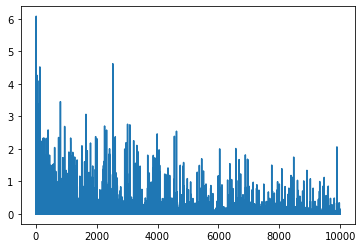

In [27]:
%matplotlib inline
plt.plot(losses)

## 3. Using a Pytorch module

In this last part, we use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

In [33]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.A = nn.Parameter(torch.randn((n_input,n_output)))
        self.b = nn.Parameter(torch.randn(1,n_output))

    def forward(self, x):
        return x @ self.A + self.b
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        return torch.max(torch.zeros_like(x),x)

In [34]:
# the grid for plotting the decision boundary should be now made of tensors.
to_forward = torch.from_numpy(np.array(list(zip(xx.ravel(), yy.ravel())))).float()

In [35]:
h=50

# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)
my_model = nn.Sequential(MyLinear_mod(2,h), MyReLU_mod(), MyLinear_mod(h,1), nn.Sigmoid())

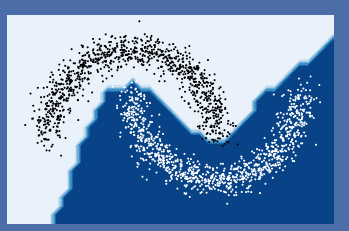

In [36]:
from torch import optim
optimizer = optim.SGD(my_model.parameters(), lr=1e-2)

X_torch = torch.from_numpy(X).float()
Y_torch = torch.from_numpy(Y).float()

# you should comment the following line if on colab
#%matplotlib notebook
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

losses = []
criterion = nn.BCELoss()
for it in range(10000):
    # pick a random example id 
    j = np.random.randint(1, len(X))

    # select the corresponding example and label
    example = X_torch[j:j+1]
    label = Y_torch[j:j+1].unsqueeze(1)

    # do a forward pass on the example
    output = my_model(example)

    # compute the loss according to your output and the label
    loss = criterion(output,label)
    losses.append(loss)

    # zero the gradients
    optimizer.zero_grad()

    # backward pass
    loss.backward()

    # gradient step
    optimizer.step()

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, my_model)
        fig.canvas.draw()
plot_decision_boundary(ax, X,Y, my_model)
fig.canvas.draw()

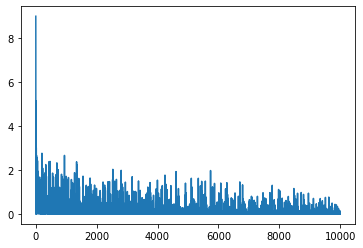

In [37]:
%matplotlib inline
plt.plot(losses)